# Imports

### Installs

In [1]:
!pip install pkbar

### Libraries

In [2]:
# Model creation
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import pkbar

# Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print(torch.__version__)
print(torchvision.__version__)

1.7.0+cu101
0.8.1+cu101


### Device

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset

In [5]:
# Load banana dataset
np_banana = np.load('/content/drive/MyDrive/datas/quickdraw/full_numpy_bitmap_banana.npy')

In [6]:
# Load axe dataset
np_axe = np.load('/content/drive/MyDrive/datas/quickdraw/full_numpy_bitmap_axe.npy')

### Functions

Function to pretty print a 2d numpy matrix

In [7]:
def pprint_numpy_matrix(mat, fmt="g"):
    """Pretty print a numpy matrix"""

    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]

    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

### Constants

In [8]:
BATCH_SIZE = 64

# Exploratory Data Analysis

### Axe dataset

#### Reshape

This dataset has nearly 125.000 entries. It contains flattened 28x28 images 

In [9]:
np_axe.shape

(124122, 784)

Reshape to 28x28

In [10]:
np_axe = np_axe.reshape((np_axe.shape[0], 1, 28, 28))

In [11]:
np_axe.shape

(124122, 1, 28, 28)

#### Visulalization

In [12]:
index = 5

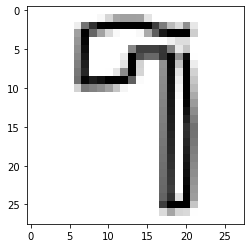

In [13]:
# Plot the image
plt.imshow(np_axe[index].squeeze(), cmap='Greys', interpolation='nearest')
plt.show()

#### Create Torch dataset

In [14]:
# Rescale to [0, 1] float32
np_axe = np_axe / 255.0
np_axe = np_axe.astype('float32')

print("min", np_axe.min())
print("max", np_axe.max())

min 0.0
max 1.0


Create tensors of the images and labels. Label for axe = **0**

In [15]:
# Create a tensor from the images
axe_x = torch.Tensor(np_axe)

# Create a tensor with the labels
axe_labels = np.full((np_axe.shape[0],), 0)
axe_y = torch.Tensor(axe_labels)

Create a dataset

In [16]:
# Create a torch dataset
axe = torch.utils.data.TensorDataset(axe_x, axe_y)

### Banana dataset

#### Reshape

This dataset has 300.000+ entries. It contains flattened 28x28 images

In [17]:
np_banana.shape

(307936, 784)

Reshape to 28x28

In [18]:
np_banana = np_banana.reshape((np_banana.shape[0], 1, 28, 28))

In [19]:
np_banana.shape

(307936, 1, 28, 28)

#### Visualization

In [20]:
index = 0

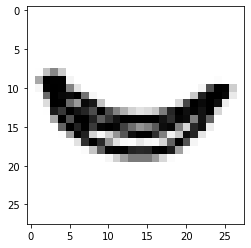

In [21]:
# Plot the image
plt.imshow(np_banana[index].squeeze(), cmap='Greys', interpolation='nearest')
plt.show()

#### Create Torch dataset

In [22]:
# Rescale to [0, 1] float32
np_banana = np_banana / 255.0
np_banana = np_banana.astype('float32')

print("min", np_banana.min())
print("max", np_banana.max())

min 0.0
max 1.0


Create tensors of the images and labels. Label for banana = **1**

In [23]:
# Create a tensor from the images
banana_x = torch.Tensor(np_banana)

# Create a tensor with the labels
banana_labels = np.full((np_banana.shape[0],), 1)
banana_y = torch.Tensor(banana_labels)

Create a dataset

In [24]:
# Create a torch dataset
banana = torch.utils.data.TensorDataset(banana_x, banana_y)

# Creation Data Loader

To use the data with a PyTorch model, we need to create data loaders from the dataset.

In [25]:
# Concatenate the datasets
dataset = torch.utils.data.ConcatDataset([axe, banana])

In [26]:
len(dataset)

432058

In [27]:
# Split the lenght of the whole dataset - 70%/30%
whole_lenght = len(dataset)

train_lenght = int((0.7 * whole_lenght))
test_lenght = whole_lenght - train_lenght

print("train len:", train_lenght, "test len:", test_lenght)

train len: 302440 test len: 129618


In [28]:
# Split the dataset

train, test = torch.utils.data.random_split(
    dataset,
    [train_lenght, test_lenght],
    generator=torch.Generator().manual_seed(42)
)

In [29]:
# Create the data loader

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

# Model

### Creation

In [30]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # Features detector
        self.features1 = nn.Sequential(
            
            # Hidden layer 1
            nn.Conv2d(1, 32, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(32),

            # Hidden layer 2
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.2)
        )

        # Features detector
        self.features2 = nn.Sequential(
            
            # Hidden layer 3
            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(64),

            # Hidden layer 4
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.3)
        )

        # Features detector
        self.features3 = nn.Sequential(
            
            # Hidden layer 4
            nn.Conv2d(64, 128, kernel_size=3, padding=(1, 1)), nn.ReLU(),
            nn.BatchNorm2d(128),

            # Hidden layer 5
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.4),
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128, 128), nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),

            # Output layer
            nn.Linear(128, 2)
        )

    def forward(self, X):

        # Features
        X = self.features1(X)
        X = self.features2(X)
        X = self.features3(X)

        # Classifier
        #X = X.view(-1, 64*128*1*1)
        X = X.view(X.size(0), -1)
        X = self.classifier(X)

        return F.log_softmax(X, dim=1)

In [31]:
model = CNN()
model.to(device)

CNN(
  (features1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (features2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.3, inplace=False)
  )
  (features3

### Evaluation function

In [32]:
class ProgressBar:

    def __init__(self, dataset_len, batch_size, max_epochs, current_epoch):
        
        self.correct = 0
        self.batch_size = batch_size

        train_per_epoch = (dataset_len - (dataset_len % self.batch_size)) / self.batch_size
        self.bar = pkbar.Kbar(target=train_per_epoch + 1,
                              epoch=current_epoch,
                              num_epochs=max_epochs,
                              width=30,
                              always_stateful=False)

    def update(self, output, y_batch, batch_id, loss):

        # Math the train loss and accuracy for current batch
        predicted = torch.max(output.data, 1)[1]
        self.correct += (predicted == y_batch).sum()
        accuracy = float(self.correct * 100) / float(self.batch_size * (batch_id + 1))

        self.bar.update(batch_id, values=[("loss", loss.data), ("accuracy", accuracy)])
        return loss.data, accuracy

    def evaluate(self, model, criterion, test_loader):
        correct = 0

        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            output = model(X_batch)
            loss = criterion(output, y_batch.long())

            # Math correct output
            predicted = torch.max(output, 1)[1]
            correct += (predicted == y_batch).sum()

        accuracy = float(correct * 100) / float(self.batch_size * len(test_loader))

        self.bar.add(1, values=[("val_loss", loss), ("val_accuracy", accuracy)])
        return loss, accuracy

In [33]:
class History:

  def __init__(self):

    self.loss = {}
    self.accuracy = {}

    self.val_loss = []
    self.val_accuracy = []
  

  def add_train(self, index, loss, accuracy):
    self.loss[index] = loss.item()
    self.accuracy[index] = accuracy
  
  def append_valication(self, index, loss, accuracy):
    self.val_loss.append(loss.item())
    self.val_accuracy.append(accuracy)

### Training function

In [34]:
  EPOCHS = 2

In [35]:
def fit(model, train_loader, test_loader):

  # Set the history dict
  history = History()

  # Define model loss function and optimizer
  optimizer = torch.optim.Adam(model.parameters())
  criterion = nn.CrossEntropyLoss()

  model.train()

  # Loop for each epochs
  for epoch in range(EPOCHS):
    progress = ProgressBar(len(train_loader.dataset), BATCH_SIZE, EPOCHS, epoch)

    # Loop for each batch
    for batch_id, (X_batch, y_batch) in enumerate(train_loader):
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      # Training pass
      optimizer.zero_grad()

      output = model(X_batch)
      loss = criterion(output, y_batch.long())

      # Model learn by backpropagating
      loss.backward()
      optimizer.step()

      history_loss, history_acc = progress.update(output, y_batch, batch_id, loss)
      history.add_train(epoch, history_loss, history_acc)

    history_val_loss, history_val_acc = progress.evaluate(model, criterion, test_loader)
    history.append_valication(epoch, history_val_loss, history_val_acc)
  
  return history

### Training

In [36]:
history = fit(model, train_loader, test_loader)

Epoch: 1/2
4726/4726 [==============================] - 50s 11ms/step - loss: 0.0606 - accuracy: 96.9056 - val_loss: 0.0015 - val_accuracy: 98.2547
Epoch: 2/2
4726/4726 [==============================] - 51s 11ms/step - loss: 0.0391 - accuracy: 98.4578 - val_loss: 0.0079 - val_accuracy: 98.4360


# Evaluation

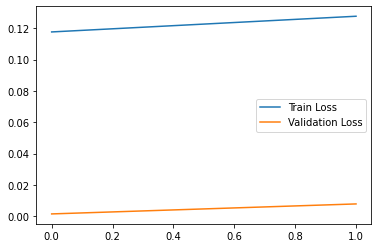

In [37]:
plt.plot(list(history.loss.values()), label='Train Loss')
plt.plot(history.val_loss, label='Validation Loss')
plt.legend()

plt.show()

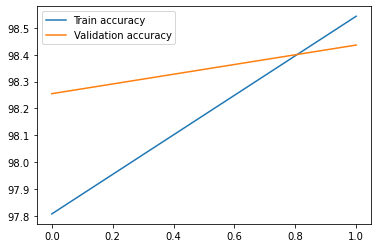

In [38]:
plt.plot(list(history.accuracy.values()), label='Train accuracy')
plt.plot(history.val_accuracy, label='Validation accuracy')
plt.legend()
plt.show()

# Exportation

In [40]:
torch.save(model.state_dict(), "model.pt")